## Vehicle routing problem (VRP)

Vehicle routing problems (VRPs) are combinatorial optimization problems that arise in the area of logistics [1].
In most variants, a set of customers needs to be visited and served (delivering or picking some goods) by a given fleet of vehicles. 

We want to find
* a visiting sequence of customers for each vehicle
* with minimal total routing costs, such that
* each customer is visited exactly once,
* the vehicle capacity is never exceeded,
* and potentially other constraints are satisfied, e.g., time windows at the customers.

In VRPs, the goal is to find optimal routes for multiple vehicles visiting a set of locations.

An optimal routes for a VRP is the routes with the least total distance.

A better way to define optimal routes is to minimize the length of the longest single route among all vehicles. 
This is the right definition if the goal is to complete all deliveries as soon as possible. 

Other ways of generalizing the TSP by adding constraints on the vehicles:

* Capacity constraints: the vehicles need to pick up items at each location they visit, but have a maximum carrying capacity.

* Time windows: each location must be visited within a specific time window.

[1] Toth, P., & Vigo, D. (Eds.). (2014). Vehicle routing: problems, methods, and applications. Society for industrial and applied mathematics.


### Capacitated vehicle routing problem (CVRP)

#### Data

* $n$, the number of clientes
* $C$, set of clients, with $C=\{1,2,...,n\}$
* $V$, set of vetices (or nodes), with $V=\{0\}\cup C$
* $A$, set of arcs, with $A=\{(i,j)\in V \times V : i\neq j\}$
* $c_{ij}$, cost of travel over arc $(i,j)\in A$
* $Q$, the vehicle capacity
* $q_i$, the amount that has to be delivered to customer $i\in N$


#### Variables

* $
x_{ij} =
\left\{
\begin{array}{rl}
1, & \text{ if arc } (i,j) \text{ is active} \\
0, & \text{ otherwise}
\end{array}
\right.
$

* $u_i$, capacity of $i \in C$

#### MIP formulation

$$\begin{align}
\min \quad & \sum_{i,j\in A} c_{ij} x_{ij} \\
\text{s.t.} \quad & \sum_{j\in V , j\neq i} x_{ij} = 1  && i \in C \\
& \sum_{i\in V , i\neq j} x_{ij} = 1 && j \in C \\
& \text{if} \ x_{ij}=1 \ \Rightarrow \ u_i + q_j = u_j && i,j \in A : j\neq 0, i\neq 0 \\
& q_i \leq u_i \leq Q && i \in C \\
& x_{ij} \in \{0,1\} && i,j \in A
\end{align}$$

In [19]:
# library
import gurobipy as gp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [20]:
# vertices
n = 10
C = [i for i in range(n) if i!=0] # clients set
V = [0] + C # vertices set
A = [(i,j) for i in V for j in V if i!=j]

# demand
np.random.seed(0)
q = {n: np.random.randint(10,15) for n in C}
q[0] = 0
Q = 50

# coord
X = np.random.rand(len(V)) * 100
Y = np.random.rand(len(V)) * 100

# distance
distance = {
    (i,j): np.hypot(X[i]-X[j],Y[i]-Y[j]) for i in V for j in V if i!=j
}

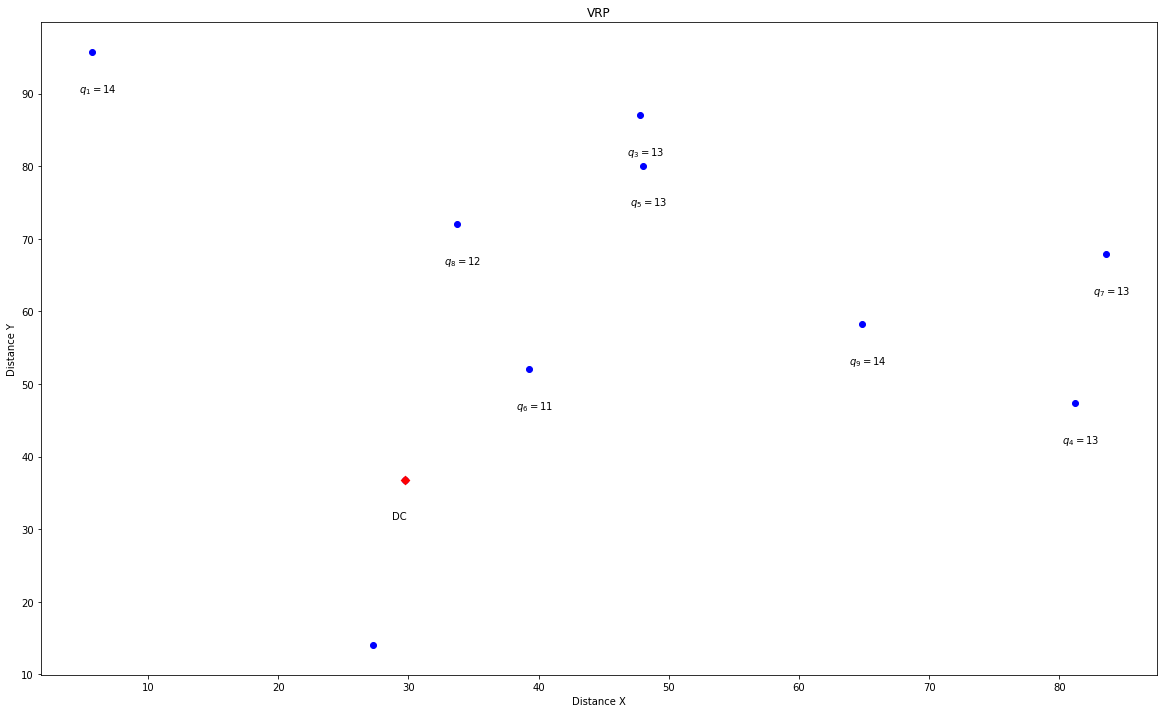

In [21]:
# print graph

plt.figure(figsize=(20,12))
plt.scatter(X,Y,color='blue')

# center
plt.scatter(X[0],Y[0],color='red',marker='D')
plt.annotate("DC",(X[0]-1,Y[0]-5.5))

for i in C:
    plt.annotate('$q_{%d}=%d$' %(i,q[i]),(X[i]-1,Y[i]-5.5))

plt.xlabel("coordinate X")
plt.ylabel("coordinate Y")
plt.title("VRP")
plt.show()

In [ ]:
# parameters

MAX_CPU_TIME = 3600.0
EPSILON = 1e-6

In [22]:
# Formulations

# model
model = gp.Model("CVRP")

# variables
x = model.addVars(A, vtype = gp.GRB.BINARY, name = 'x')
u = model.addVars(C, ub=Q, vtype = gp.GRB.CONTINUOUS, name = 'u')

# objective
model.setObjective(gp.quicksum(distance[i,j] * x[i,j] for i,j in A), gp.GRB.MINIMIZE)

# constraints
model.addConstrs(gp.quicksum(x[i,j] for j in V if j!=i) == 1 for i in C)
model.addConstrs(gp.quicksum(x[i,j] for i in V if i!=j) == 1 for j in C)
model.addConstrs((x[i,j] == 1) >> (u[i]+q[j] == u[j]) for i,j in A if j!=0 and i!=0)
model.addConstrs(u[i] >= q[i] for i in C)
model.addConstrs(u[i] <= Q for i in C)

# export .lp
#model.write(file_name+"_model.lp")

# parameters 
model.setParam(gp.GRB.Param.TimeLimit, MAX_CPU_TIME)
model.setParam(gp.GRB.Param.MIPGap, EPSILON)
model.setParam(gp.GRB.Param.Threads, 1)
#model.setParam(gp.GRB.Param.Cuts, -1)
#model.setParam(gp.GRB.Param.Presolve, -1)

# turn off display
gp.setParam('OutputFlag', 0)

# open log file
#_ = open('log/cvrp.log', 'w')

# optimize model
model.optimize() 

tmp = 0
if model.status == gp.GRB.OPTIMAL:
    tmp = 1

ub = model.objBound
lb = model.objVal
gap = model.MIPGap
time = model.Runtime
nodes = model.NodeCount
status = tmp

In [23]:
print("ub= ", round(ub,2))
print("lb =", round(lb,2))
print("gap = ", round(gap,2))
print("time = ", round(time,2))
print("nodes = ", round(nodes,2))
print("status = ", tmp)

ub=  403.89
lb = 403.89
gap =  0.0
time =  1.54
nodes =  3747.0
status =  1


In [24]:
# print soluções
print("optimal: ", str(round(model.objVal,2)))
for v in model.getVars():
    if v.x > 0.9:
        print(str(v.VarName)+"="+str(round(v.x,2)))

optimal:  403.89
x[0,2]=1.0
x[0,5]=1.0
x[0,8]=1.0
x[1,0]=1.0
x[2,4]=1.0
x[3,1]=1.0
x[4,7]=1.0
x[5,3]=1.0
x[6,0]=1.0
x[7,9]=1.0
x[8,6]=1.0
x[9,0]=1.0
u[1]=50.0
u[2]=10.0
u[3]=36.0
u[4]=23.0
u[5]=23.0
u[6]=23.0
u[7]=36.0
u[8]=12.0
u[9]=50.0


In [25]:
# optimal tour
opt_router = list()
for i in C:
    if x[(0,i)].x > 0.9:
        aux = [0,i]
        while i!=0:
            j=i
            for k in V:
                if j!=k and x[(j,k)].x > 0.9:
                    aux.append(k)
                    i = k
        opt_router.append(aux)

print(opt_router)

[[0, 2, 4, 7, 9, 0], [0, 5, 3, 1, 0], [0, 8, 6, 0]]


In [26]:
Color = { 
    0 : 'blue',
    1 : 'orange',
    2 : 'green',
    3 : 'red',
    4 : 'purple',
    5 : 'brown',
    6 : 'pink',
    7 : 'gray',
    8 : 'olive',
    9 : 'cyan',
    10 : 'yellow',
    11 : 'violet',
    12 : 'lime',
    13 : 'azure',
    14 : 'gold',
    15 : 'tan'
}

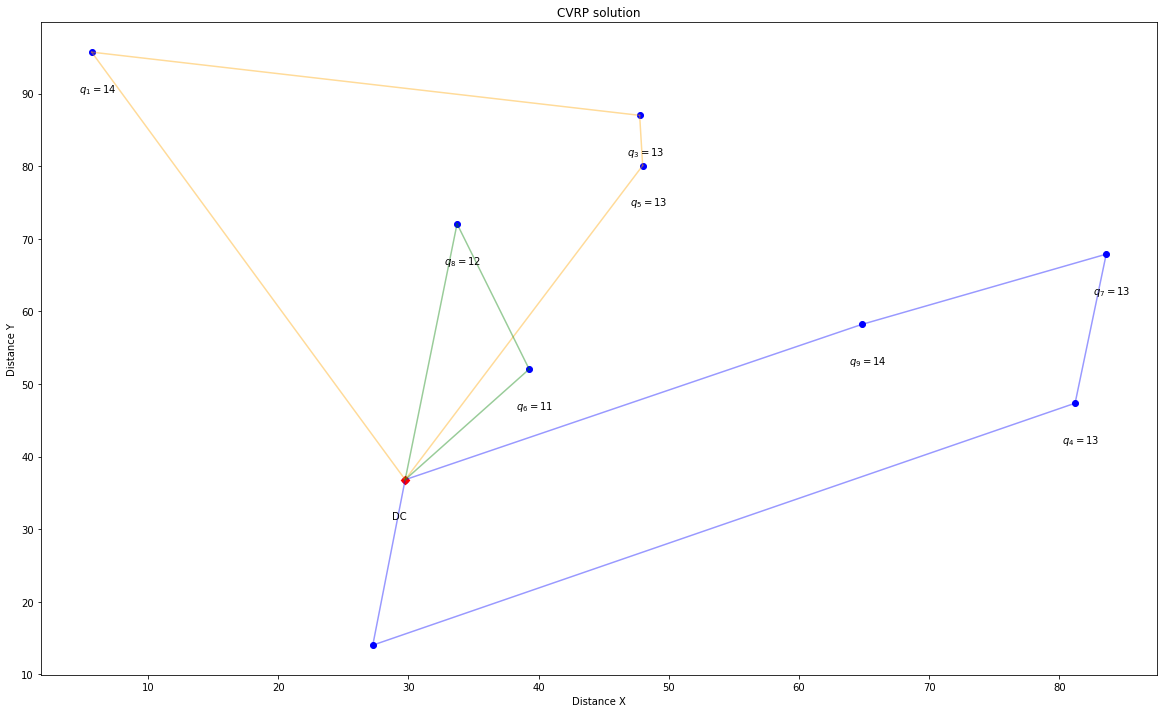

In [27]:
#print graph

plt.figure(figsize=(20,12))
plt.scatter(X,Y,color='blue')

# DC
plt.scatter(X[0],Y[0],color='red',marker='D')
plt.annotate("DC",(X[0]-1,Y[0]-5.5))

for i in C:
    plt.annotate('$q_{%d}=%d$' %(i,q[i]),(X[i]-1,Y[i]-5.5))
    
# print rotas
for r in range(len(opt_router)):
    for n in range(len(opt_router[r])-1):
        i = opt_router[r][n]
        j = opt_router[r][n+1]
        plt.plot([X[i],X[j]],[Y[i],Y[j]],color=Color[r], alpha=0.4)
        
plt.xlabel("Distance X")
plt.ylabel("Distance Y")
plt.title("CVRP solution")
plt.show()

### Vehicle Routing Problem With Time Windows (VRPTW)

#### Data

* $C$: set of clients
* $V = \{0\} \cup C$: set of vertices, where 0 is the distribution center.
* $A = \{ (i,j) \in V \times V \; : \; i \not= j  \}$: set of arcs.
* $q_i$: demand of each client.
* $Q$: capacity of vehicle.
* $K = \{ 1,2, \ldots, n \}$, set of vehicles.

#### Variables

* $
x_{i,j,k} = 
\left\{
\begin{array}{lr}
1, \text{ if arc } (i,j) \in A \text{ is used by vehicle } k. \\
0, \text{ otherwise}
\end{array}
\right.
$

* $t_{ik}$, tempo em que se inicia o serviço no vértice $i \in N$, com o veículo $k \in K$

#### MIP Formulation

\begin{align}
z = \min & \sum_{k \in K} \sum_{(i,j) \in A} c_{i,j,k} x_{i,j,k} \\
& \sum_{j \in C} x_{0,j,k} \leq 1 \; \forall k \in K \\
& \sum_{i \in C} x_{i,0,k} \leq 1 \; \forall k \in K \\
& \sum_{j \in V} \sum_{k \in K} x_{i,j,k} = 1 \; \forall i \in C \\
& \sum_{j \in V} x_{i,j,k} - \sum_{j \in V} x_{j,i,k} = 0 \; \forall k \in K, \; \forall i \in C \\
& \sum_{i \in C} q_i \sum_{j \in V} x_{i,j,k} \leq Q, \forall k \in K \\
& \text{if } x_{i,j,k} = 1 \to t_{ik} + s_i + T_{i,j} = t_{j,k} \; \forall k \in K, \; \forall (i,j) \in A \\
& e_i \leq t_{i,k} \leq l_{i} \; \forall i \in V, \; \forall k \in K.
\end{align}

In [28]:
# clients, vertices, arcs
n = 11
C = [i for i in range(n) if i!=0]
V = [0] + C
A = [(i,j) for i in V for j in V if i!=j]

In [29]:
# demand
np.random.seed(0)
q = {n : np.random.randint(10,15) for n in C}
q[0] = 0

In [30]:
# sales time

# minimum arrival time
e = {0:0, 1:10, 2:10, 3:10, 4:20, 5:20, 6:20, 7:40, 8:40, 9:40, 10:40} 

# maximum arrival time
l = {0:200, 1:100, 2:100, 3:100, 4:150, 5:150, 6:150, 7:180, 8:180, 9:180, 10:180}

In [31]:
# service time at vertex i
s = {n: np.random.randint(3,5) for n in C}
s[0] = 0

In [32]:
# vehicles
K = [1,2,3,4]

In [33]:
# vehicles capacity
# Q = 50
Q = {1:50, 2:50, 3:25, 4:25}

In [34]:
# coordinates
X = np.random.rand(len(V))*100
Y = np.random.rand(len(V))*100

In [35]:
# distance
distance = {
    (i,j): np.hypot(X[i]-X[j],Y[i]-Y[j]) for i in V for j in V if i!=j
}

# time
timeserv = {
    (i,j): np.hypot(X[i]-X[j],Y[i]-Y[j]) for i in V for j in V if i!=j
}

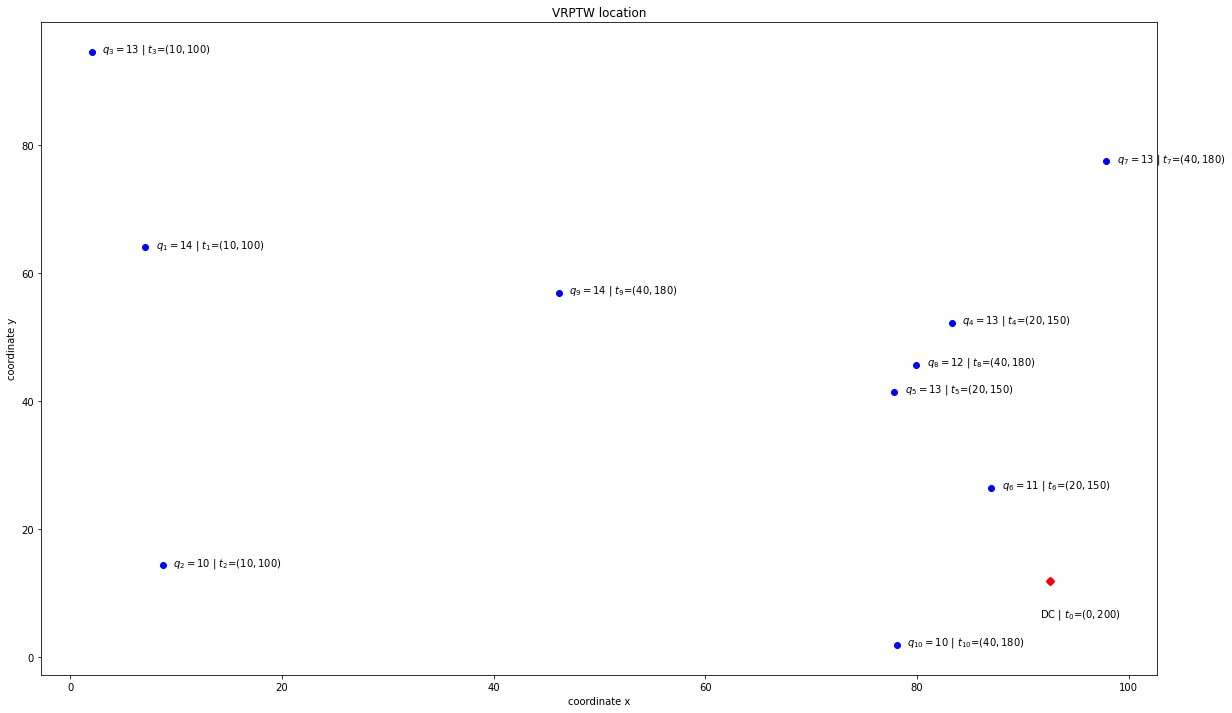

In [38]:
# graph
plt.figure(figsize=(20,12))
plt.scatter(X,Y,color='blue')

# DC: distribuition center
plt.scatter(X[0],Y[0], color='red',marker='D')
plt.annotate("DC | $t_{%d}$=(%d$,%d$)" %(0,e[0],l[0]),(X[0]-1,Y[0]-5.5))

for i in C:
    plt.annotate('$q_{%d}=%d$ | $t_{%d}$=(%d$,%d$)' %(i,q[i],i,e[i],l[i]),(X[i]+1,Y[i]))

plt.xlabel("coordinate x")
plt.ylabel("coordinate y")
plt.title("VRPTW location")

plt.show()

In [39]:
# MIP formulation

# arcs
arcos = [(i,j,k) for i in V for j in V for k in K if i!=j]

arcos_t = [(i,k) for i in V for k in K]

# model
model = gp.Model("VRPTW")

# variables
x = model.addVars(arcos, vtype=gp.GRB.BINARY, name='x')
t = model.addVars(arcos_t, vtype=gp.GRB.CONTINUOUS, name='t')

# objective
model.setObjective(gp.quicksum(distance[i,j]*x[i,j,k] for i,j,k in arcos), gp.GRB.MINIMIZE)

# constraints

# arrival and departure of vehicles from DC
model.addConstrs(gp.quicksum(x[0,j,k] for j in C) <= 1 for k in K)
model.addConstrs(gp.quicksum(x[i,0,k] for i in C) <= 1 for k in K)

# one vehicle per vertices
model.addConstrs(gp.quicksum(x[i,j,k] for j in V for k in K if i!=j) == 1 for i in C)

# flux conservation
model.addConstrs(
    gp.quicksum(x[i,j,k] for j in V if i!=j) - gp.quicksum(x[j,i,k] for j in V if i!=j) == 0
    for i in V for k in K
)

# vehicle capacity
model.addConstrs(
    gp.quicksum(q[i] * gp.quicksum(x[i,j,k] for j in V if i!=j) for i in C) <= Q[k] for k in K
)

# time window
# indicator constraint
# subtour elimination
model.addConstrs(
    (x[i,j,k]==1) >> (t[i,k]+s[i]+timeserv[i,j]==t[j,k]) 
    for i in C for j in C for k in K if i!=j
)

model.addConstrs(t[i,k] >= e[i] for i,k in arcos_t)
model.addConstrs(t[i,k] <= l[i] for i,k in arcos_t)

# export .lp
#model.write(file_name+"_model.lp")

# parameters 
model.setParam(gp.GRB.Param.TimeLimit, MAX_CPU_TIME)
model.setParam(gp.GRB.Param.MIPGap, EPSILON)
model.setParam(gp.GRB.Param.Threads, 1)
#model.setParam(gp.GRB.Param.Cuts, -1)
#model.setParam(gp.GRB.Param.Presolve, -1)

# turn off display
gp.setParam('OutputFlag', 0)

# open log file
#_ = open('vrptw.log', 'w')

# optimize model
model.optimize() 

tmp = 0
if model.status == gp.GRB.OPTIMAL:
    tmp = 1

# get solution
ub = model.objBound
lb = model.objVal
gap = model.MIPGap
time = model.Runtime
nodes = model.NodeCount
status = tmp

In [40]:
# print solution

print("Objective:", str(round(model.ObjVal,2)))

for v in model.getVars():
    if v.x > 0.9:
        print(str(v.VarName)+" = "+str(round(v.x,2)))

Objective: 587.21
x[0,3,1] = 1.0
x[0,4,2] = 1.0
x[0,6,4] = 1.0
x[0,8,3] = 1.0
x[1,2,1] = 1.0
x[2,10,1] = 1.0
x[3,1,1] = 1.0
x[4,7,2] = 1.0
x[5,0,3] = 1.0
x[6,0,4] = 1.0
x[7,9,2] = 1.0
x[8,5,3] = 1.0
x[9,0,2] = 1.0
x[10,0,1] = 1.0
t[1,1] = 43.9
t[1,2] = 100.0
t[1,3] = 10.0
t[1,4] = 10.0
t[2,1] = 96.58
t[2,2] = 100.0
t[2,3] = 10.0
t[2,4] = 10.0
t[3,1] = 10.0
t[3,2] = 100.0
t[3,3] = 100.0
t[3,4] = 100.0
t[4,1] = 150.0
t[4,2] = 20.0
t[4,3] = 150.0
t[4,4] = 20.0
t[5,1] = 137.31
t[5,2] = 150.0
t[5,3] = 47.65
t[5,4] = 32.35
t[6,1] = 150.0
t[6,2] = 150.0
t[6,3] = 20.0
t[6,4] = 20.0
t[7,1] = 157.31
t[7,2] = 53.16
t[7,3] = 180.0
t[7,4] = 127.15
t[8,1] = 180.0
t[8,2] = 180.0
t[8,3] = 40.0
t[8,4] = 40.0
t[9,1] = 157.31
t[9,2] = 112.82
t[9,3] = 180.0
t[9,4] = 180.0
t[10,1] = 170.03
t[10,2] = 180.0
t[10,3] = 180.0
t[10,4] = 40.0


In [41]:
tour = list()
truck = list()
Kaux = K
Naux = V
for k in K:
    for i in V:
        if i!=0 and x[(0,i,k)].x > 0.9:
            aux = [0,i]
            while i!=0:
                j = i
                for h in V:
                    if j!=h and x[(j,h,k)].x > 0.9:
                        aux.append(h)
                        i = h
            tour.append(aux)
            truck.append(k)
print(tour)
print(truck)

[[0, 3, 1, 2, 10, 0], [0, 4, 7, 9, 0], [0, 8, 5, 0], [0, 6, 0]]
[1, 2, 3, 4]


In [42]:
# time calculation
time_acum = list()
for n in range(len(tour)):
    for k in range(len(tour[n])-1):
        if k==0:
            aux=[0]
        else:
            i=tour[n][k]
            j=tour[n][k+1]
            t = timeserv[i,j]+s[i]+aux[-1]
            aux.append(t)
    time_acum.append(aux)

In [43]:
Color = { 
    0 : 'blue',
    1 : 'orange',
    2 : 'green',
    3 : 'red',
    4 : 'purple',
    5 : 'brown',
    6 : 'pink',
    7 : 'gray',
    8 : 'olive',
    9 : 'cyan',
    10 : 'yellow',
    11 : 'violet',
    12 : 'lime',
    13 : 'azure',
    14 : 'gold',
    15 : 'tan'
}

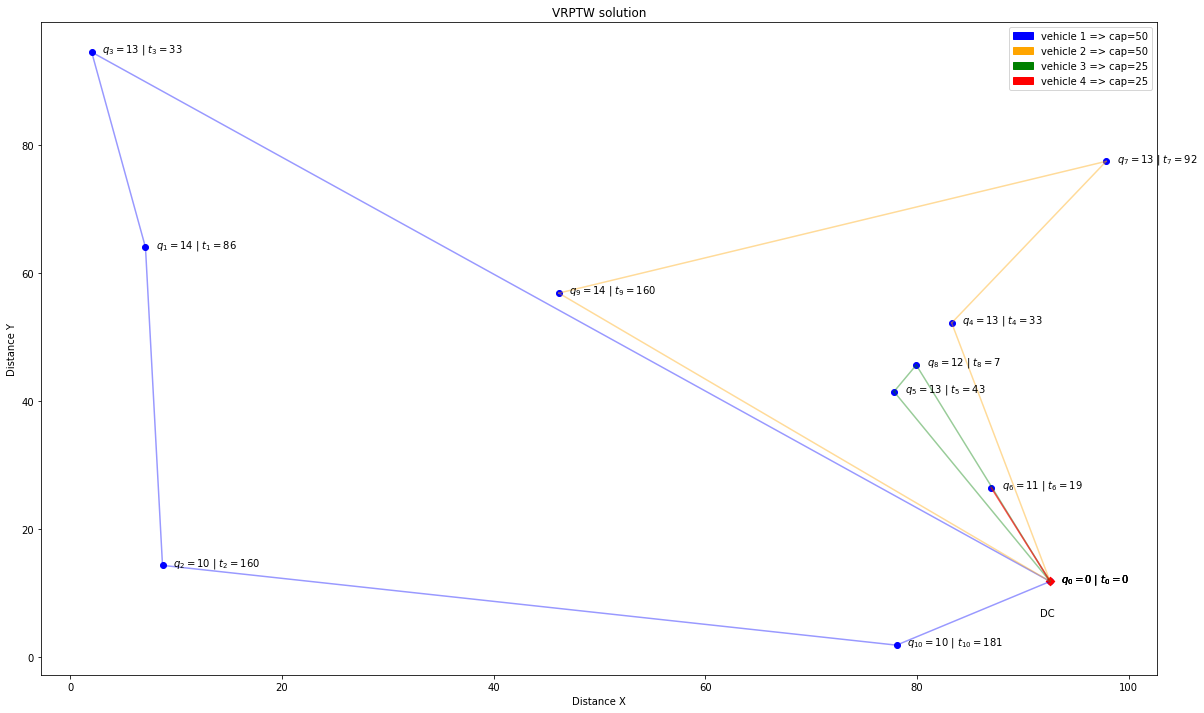

In [44]:
# print graph solution

plt.figure(figsize=(20,12))
plt.scatter(X,Y,color='blue')

# DC: distribution center
plt.scatter(X[0],Y[0], color='red',marker='D')
plt.annotate("DC",(X[0]-1,Y[0]-5.5))

# routes
for r in range(len(tour)):
    for n in range(len(tour[r])-1):
        i = tour[r][n]
        j = tour[r][n+1]
        plt.plot([X[i],X[j]],[Y[i],Y[j]],color=Color[r],alpha=0.4)

for r in range(len(time_acum)):
    for n in range(len(time_acum[r])):
        i = tour[r][n]
        plt.annotate(
            '$q_{%d}=%d$ | $t_{%d}=%d$' %(i,q[i],i,time_acum[r][n]),(X[i]+1,Y[i])
        )
        
        
patch = [
    mpatches.Patch(
        color=Color[n],label="vehicle "+str(truck[n])+" => cap="+str(Q[truck[n]])
    )
    for n in range(len(truck))
]

plt.legend(handles=patch,loc='best')
plt.xlabel("Distance X")
plt.ylabel("Distance Y")
plt.title("VRPTW solution")
plt.show()